# Benchmark

This benchmark is based on [this article](https://www.depends-on-the-definition.com/identify-ingredients-with-neural-networks/) with some minor adaptations for the problem we are trying to solve.

## Learn to identify ingredients with neural networks

**Author**: Today we want to build a model, that can identify ingredients in cooking recipes. I use the [German Recipes Dataset](https://www.kaggle.com/sterby/german-recipes-dataset), I recently published on kaggle. We have more than 12000 German recipes and their ingredients list. First we will generate labels for every word in the recipe, if it is an ingredient or not. Then we use a sequence-to-sequence neural network to tag every word. Then we pseudo-label the training set and update the model with the new labels.

In [1]:
try:
    already_initialized
except NameError:
    !python -m pip install --upgrade pip
    !pip install spacy==2.3.5
    !python -m spacy download de_core_news_sm
    !pip install tensorflow
    !pip install keras
    already_initialized = True

     |████████████████████████████████| 1.5 MB 22.9 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 21.1.2
    Uninstalling pip-21.1.2:
      Successfully uninstalled pip-21.1.2
     |████████████████████████████████| 10.4 MB 11.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 61.4 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 78.0 MB/s eta 0:00:01
     |████████████████████████████████| 184 kB 79.4 MB/s eta 0:00:01
     |████████████████████████████████| 76 kB 7.1 MB/s  eta 0:00:01
     |████████████████████████████████| 9.8 MB 62.6 MB/s eta 0:00:01
     |████████████████████████████████| 14.9 MB 6.0 MB/s eta 0:00:01
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.3.0-py3-none-any.whl size=14907581 sha256=f573c692093fe44a9d4eb5b48ee39d8a8604f7c90cbebf1e7216bdae69fc7743
  Stored in directory: /tmp/pip-ephem-wheel-cache-d1ge0xvy/wheels/fe/44/0f/7270b8ec13bc290e606a3c0f52f981915b1d09d1dfc7c79088
Successf

In [2]:
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)
print(tf.keras.__version__)

2.5.0
2.5.0


## Load the recipes

In [45]:
df = pd.read_json("data/recipes.json")
df.head(10)

,Url,Instructions,Ingredients,Day,Name,Year,Month,Weekday
0,https://www.chefkoch.de/rezepte/185441079701305/,Die Eier hart kochen. Dann pellen und mit eine...,"[600 g Hackfleisch, halb und halb, 800 g Sauer...",1,Gebratener Hasenrücken,2009,January,Thursday
1,https://www.chefkoch.de/rezepte/2718181424631245/,Vorab folgende Bemerkung: Alle Mengen sind Cir...,"[1 kg Strauchtomate(n), 1 Gemüsezwiebel(n), 1 ...",1,Pilz Stroganoff,2017,July,Saturday
2,https://www.chefkoch.de/rezepte/46341015661368/,"Die Kirschen abtropfen lassen, dabei den Saft ...","[1 Glas Kirsche(n), 1 Pck. Vanillepuddingpulve...",1,Kaninchen a la Gioff,2007,January,Monday
3,https://www.chefkoch.de/rezepte/51051018014178/,"Den Spargel säubern, die holzigen Enden abschn...","[500 g Spargel, grüner, 300 ml Brühe oder Fond...",1,Spanisches Knoblauch-Kaninchen,2013,April,Monday
4,https://www.chefkoch.de/rezepte/1555771262860408/,Kohlrabi schälen und klein würfeln. Mit der Br...,"[250 g Kohlrabi, 150 ml Gemüsebrühe, 150 ml Mi...",1,Gnocchi - Hack - Pfanne mit Basilikum,2017,August,Tuesday
5,https://www.chefkoch.de/rezepte/318661113606205/,"Aus dem Mehl, der Butter, dem Ei und etwas Sal...","[Für den Mürbeteig:, 200 g Weizenmehl, 100 g B...",1,Spaghetti Siracusani,2011,August,Monday
6,https://www.chefkoch.de/rezepte/307991111110164/,"Das Öl mit dem Rotwein, dem Essig, den Wachold...","[Für die Marinade:, 3 EL Öl, 5 EL Rotwein, 2 E...",1,Rehrücken in Salzkruste mit Waldpilzgulasch,2006,October,Sunday
7,https://www.chefkoch.de/rezepte/800291183649658/,Den Reis mit 2 Tassen Wasser/Gemüsebrühe aufse...,"[1 Tasse Reis, (Langkornreis), 2 Tasse/n Wasse...",1,Eier in Senfsauce,2012,March,Thursday
8,https://www.chefkoch.de/rezepte/295691108953224/,"Kartoffeln schälen, waschen, vierteln und in k...","[1200 g Kartoffel(n), mehlig kochend, 250 ml M...",1,Äppelufflaaf mett Woi,2006,April,Saturday
9,https://www.chefkoch.de/rezepte/44381015086527/,"Kartoffeln, Steckrüben, Sellerie und Zwiebel s...","[400 g Kartoffel(n), 300 g Steckrübe(n), 300 g...",1,Gefüllte Schinkenröllchen,2006,November,Wednesday


Define the test set:

In [47]:
eval_df = df[11000:]
eval_df.shape

(1190, 8)

Define the training set:

In [5]:
df = df[:11000]
df.shape

(11000, 8)

## Tokenize the texts with spacy
**Author**: Run the spacy tokenizer on all instructions.

In [6]:
nlp = spacy.load('de_core_news_sm', disable=['parser', 'tagger', 'ner'])
tokenized = [nlp(t) for t in df.Instructions.values]

Number of unique tokens: 17556


**Author**: And now we build a vocabulary of known tokens.

In [48]:
vocab = {"<UNK>": 1, "<PAD>": 0}
for txt in tokenized:
    for token in txt:
        if token.text not in vocab.keys():
            vocab[token.text] = len(vocab)
print("Number of unique tokens: {}".format(len(vocab)))

Number of unique tokens: 17556


## Create the labels
**Author**: What is missing now, are the labels. We need to know where in the text are ingredients. We will try to bootstrap this information from the provided ingredients list.

In [7]:
ingredients = df.Ingredients
ingredients[0]

['600 g Hackfleisch, halb und halb',
 '800 g Sauerkraut',
 '200 g Wurst, geräucherte (Csabai Kolbász)',
 '150 g Speck, durchwachsener, geräucherter',
 '100 g Reis',
 '1 m.-große Zwiebel(n)',
 '1 Zehe/n Knoblauch',
 '2 Becher Schmand',
 '1/2TL Kümmel, ganzer',
 '2 Lorbeerblätter',
 'Salz und Pfeffer',
 '4 Ei(er) (bei Bedarf)',
 'Paprikapulver',
 'etwas Wasser',
 'Öl']

**Author**: We first clean the ingredients lists from stopwords, numbers and other stuff.

In [8]:
def _filter(token):
    if len(token) < 2:
        return False
    if token.is_stop:
        return False
    if token.text[0].islower():
        return False
    if token.is_digit:
        return False
    if token.like_num:
        return False
    return True

def _clean(text):
    text = text.replace("(", "")
    text = text.split("/")[0]
    return text

In [9]:
clean = [_clean(t.text) for i in ingredients[214] for t in nlp(i) if _filter(t) and len(_clean(t.text)) >= 2]
clean

['Rosenkohl',
 'Schalotte',
 '2Tasse',
 'Hühnerbrühe',
 'Milch',
 'EL',
 'Crème',
 'Speck',
 'Kartoffelgnocchi']

In [10]:
def get_labels(ingredients, tokenized_instructions):
    labels = []
    for ing, ti in zip(ingredients, tokenized_instructions):
        l_i = []
        ci = [_clean(t.text) for i in ing for t in nlp(i) if _filter(t) and len(_clean(t.text)) >= 2]
        label = []
        for token in ti:
            l_i.append(any((c == token.text or c == token.text[:-1] or c[:-1] == token.text) for c in ci))
        labels.append(l_i)
    return labels

def format_labels(labels):
    y_seq = []
    for label in labels:
        y_i = []
        for i in range(MAX_LEN):
            try:
                y_i.append(float(label[i]))
            except:
                y_i.append(0.0)
        y_seq.append(np.array(y_i))
    y_seq = np.array(y_seq)
    return y_seq.reshape(y_seq.shape[0], y_seq.shape[1], 1)

In [11]:
labels = get_labels(ingredients, tokenized)
i=214
print(labels[i])
set([t.text for t, l in zip(tokenized[i], labels[i]) if l])

[False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, True, False, True, False, True, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False,

{'Crème', 'Hühnerbrühe', 'Milch', 'Rosenkohl', 'Schalotten', 'Speck'}

## Modelling with a LSTM network
**Author**: First we have to look at the length of our recipes, to determine the length we want to pad our inputs for the network to.

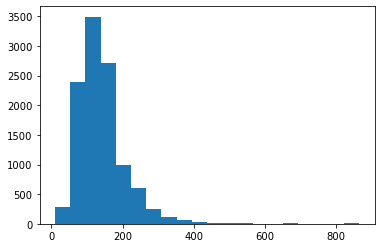

In [12]:
%matplotlib inline

plt.hist([len([t for t in tokens]) for tokens in tokenized], bins=20);

**Author**: We picked a maximum length of 400 tokens.

In [13]:
MAX_LEN = 400

## Prepare the sequences by padding
**Author**: Now we pad the sequences and map the words to integers.

In [14]:
def prepare_sequences(texts, max_len, vocab={"<UNK>": 1, "<PAD>": 0}):
    X = [[vocab.get(w.text, vocab["<UNK>"]) for w in s] for s in texts]
    return pad_sequences(maxlen=max_len, sequences=X, padding="post", value=vocab["<PAD>"])

**Author**: Using TensorFlow backend.

In [15]:
X_seq = prepare_sequences(tokenized, max_len=MAX_LEN, vocab=vocab)
X_seq[1]

array([192, 193, 194, 183, 195, 196, 128, 197,   9, 198, 199, 200, 201,
       202, 203,  60, 204, 205,   9,  13, 206,  15,  23,  98, 207, 208,
        51, 209,  68, 202, 203,  25,   6, 195, 125, 202, 210, 211, 212,
        33,  45, 213, 214, 100, 196,  13, 215, 216, 217,  33,   9,  68,
       218, 219, 213, 169,  35,  82, 100, 220, 221, 202,   6, 222,  45,
       223,  48, 224,  33,  67, 225, 100, 226,   6, 227, 228, 229, 130,
        45,  92,  85, 230, 211, 231,   6, 232, 233, 234, 235, 145, 157,
       236,   9, 237, 238, 104, 239, 210, 240, 157, 241,  54,   6, 109,
       242, 243, 244, 245, 246, 187, 247,   6, 248, 183, 249, 250,  33,
       129,  13, 251, 252, 101, 253,  33, 254,   9,  31, 255,  40, 172,
         6,   2, 256, 257, 177, 258, 259, 260,  33,  42, 261, 262, 263,
       131, 264, 265, 266,  33, 267,  74, 268, 269,  68, 270,   6,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [50]:
y_seq = format_labels(labels)

# Setup the network

**Author**: Now we can start to setup the model. We build a simple 2-layer LSTM-based sequence tagger with tensorflow.keras.

**Author**: And now we fit it.

**Yeray**: The code above was originally used to train the model. Since it takes quite some time, I saved the trained model which I then used in subsequent runs of this script.

In [17]:
model = tf.keras.models.load_model('model/benchmark_model_2021-03-13_14-57-29_loss-0.02')

## Analyse the predictions of the model
**Author**: Now that the model is trained, we can look at some predictions on the training set.

In [18]:
y_pred = model.predict(X_seq, verbose=1, batch_size=512)

22/22 [==============================] - 25s 913ms/step


**Yeray**: Define a predictions vector with True or False if the word a that particular location is an ingredient or not:**Yeray**: 

In [53]:
i = 3343
pred_i = y_pred[i] > 0.05

**Yeray**: Original text as a list of tokens:

In [20]:
tokenized[i]

Kohlrabi schälen, waschen und in Stifte schneiden. Brühe und Milch ankochen, Kohlrabi dazugeben, aufkochen lassen und 10 Minuten kochen. Dann herausnehmen und abtropfen lassen, die Brühe aufheben.Butter erhitzen, das Mehl darin anschwitzen, mit Kohlrabibrühe ablöschen und aufkochen lassen. Mit den Gewürzen abschmecken. Kohlrabi wieder dazugeben.Hähnchenbrust schnetzeln, kräftig anbraten und würzen. Das Fleisch in eine Auflaufform geben, die Speckwürfel darüber verteilen. Mit Käse bestreuen. Nun das Gemüse darüber schichten und alles bei 180 °C ca. 25 Minuten überbacken.Tipp:Man kann auch gut gekochte, in Würfel geschnittene Kartoffeln unter die Kohlrabi mischen. Ebenso kann man auch Kohlrabi und Möhren für den Auflauf nehmen. Schmeckt auch sehr lecker!

**Yeray**: The list of tokens in the text with a prediction greater than 0.05:

In [21]:
ingreds = [t.text for t, p in zip(tokenized[i], pred_i) if p]
print(set(ingreds))

{'Mehl', 'Butter', 'Kohlrabi', 'Kartoffeln', 'Speckwürfel', 'Möhren', 'Milch', 'Käse', 'Gemüse', 'Brühe'}


**Yeray**: The list of tokens in the text that were originally labeled as ingredients:

In [22]:
ingreds = [t.text for t, p in zip(tokenized[i], y_seq[i]) if p]
set(ingreds)

{'Butter', 'Kohlrabi', 'Käse', 'Mehl', 'Milch'}

**Yeray**: The actual list of ingredients used for labelling:

In [54]:
ingredients[i]

['500 g Kohlrabi',
 '1/4Liter Hühnerbrühe',
 '1/4Liter Milch',
 '1 EL Butter',
 '30 g Mehl',
 '300 g Hähnchenbrustfilet(s)',
 'Salz und Pfeffer',
 'Muskat',
 '50 g Käse, gerieben',
 '50 g Speck, gewürfelt']

**Author**: This looks very good! Our model seems to be able to identify the ingredients better than our training labels. So we now use the produced labels for fine-tuning the network.

In [24]:
new_labels = []
for pred_i, ti in zip(y_pred, tokenized):
    l_i = []
    ci = [t.text for t, p in zip(tokenized[i], pred_i > 0.05) if p]
    label = []
    for token in ti:
        l_i.append(any((c == token.text or c == token.text[:-1] or c[:-1] == token.text) for c in ci))
    new_labels.append(l_i)

In [25]:
y_seq_new = format_labels(new_labels)

**Author**: We fit the network again for one epoch with the new labels.

In [26]:
history = model.fit(X_seq, y_seq_new, epochs=1, batch_size=256, validation_split=0.1)

39/39 [==============================] - 73s 2s/step - loss: 0.2585 - accuracy: 0.7276 - val_loss: 0.1793 - val_accuracy: 0.7834


# Look at test data
**Author**: Now we can look at the test data we put aside in the beginning.

In [27]:
eval_ingredients = eval_df.Ingredients.values
eval_ingredients[0]

['500 g Rosenkohl',
 '400 g Kartoffel(n)',
 '3 Stange/n Staudensellerie',
 '2 Zwiebel(n), gewürfelte',
 '4 EL Olivenöl',
 '1 TL Currypulver',
 '1/2TL Kurkuma',
 '300 ml Gemüsebrühe',
 '3 EL Tomatenmark',
 '50 g Rosinen',
 '1/2TL Chilipulver oder frischer Chili',
 '1/2Bund Petersilie',
 '2 Banane(n)',
 '1/2 Zitrone(n), der Saft davon',
 '150 g Schlagsahne',
 '1 EL Zucker, braun bei Bedarf']

In [28]:
eval_tokenized = [nlp(t) for t in eval_df.Instructions.values]
eval_tokenized[0]

Rosenkohl putzen, die Röschen halbieren. Kartoffeln schälen und würfeln. Staudensellerie putzen und in 1 cm große Stücke schneiden. Zwiebeln schälen und würfeln.Öl in einer Pfanne erhitzen, Chili und Zwiebeln darin anbraten. Mit Currypulver und Kurkuma bestreuen. Tomatenmark zugeben und kurz mit anschwitzen (je nach Geschmack 1 EL braunen Zucker zugeben). Rosenkohl, Kartoffeln und Sellerie zugeben. Kurz andünsten und die Brühe angießen. Rosinen zugeben und mit geschlossenem Deckel ca. 15 Minuten köcheln.Die Bananen schälen und in Scheiben schneiden. Die Bananenscheiben und Zitronensaft zugeben und noch einmal 10 Minuten köcheln lassen. Die Sahne nicht ganz steif schlagen und unter das Rosenkohl-Curry heben. Mit Petersilie bestreut servieren.

In [29]:
X_seq_test = prepare_sequences(eval_tokenized, max_len=MAX_LEN, vocab=vocab)
X_seq_test[0]

array([3285,  205,   33,   98,  564,  869,    6,  520,   32,    9,   30,
          6, 3669,  205,    9,   13,  110,  333,  264,  206,   15,    6,
        585,   32,    9,   30,    6,   92,   13,  233,  420,  459,   33,
       2271,    9,  585,  422,  341,    6,  109, 1236,    9, 1680,  548,
          6,  612,  568,    9,   62,   10,  703,   23,  361,  199,  200,
        110,  277, 3670,  295,  568,   25,    6, 3285,   33,  520,    9,
        560,  568,    6,  691, 1132,    9,   98,  220,  570,    6, 1725,
        568,    9,   10, 1254,  148,  288,  571,   79,  290,    6,    2,
       3353,   32,    9,   13,   14,   15,    6,    2, 3671,    9, 1122,
        568,    9,  124,  302,  344,   79,  290,   54,    6,    2,  426,
         51,   52,  311,  312,    9,   80,   45, 3672, 1083,    6,  109,
        380,  574,  321,    6,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [30]:
eval_labels = get_labels(eval_ingredients, eval_tokenized)

y_seq_test = format_labels(eval_labels)

In [31]:
y_pred_test = model.predict(X_seq_test, verbose=1, batch_size=1024)

2/2 [==============================] - 2s 362ms/step


In [32]:
def pred(i):
    pred_i = y_pred_test[i] > 0.05
    print(eval_tokenized[i])
    print()
    print(eval_ingredients[i])
    print()
    ingreds = [t.text for t, p in zip(eval_tokenized[i], pred_i) if p]
    print(set(ingreds))

In [33]:
pred(893)

Den Quark durch ein Sieb in eine tiefe Schüssel streichen.Das Mehl, den Zucker, Salz, Vanillezucker und das rohe Ei/er gut verrühren.Diese Masse auf einem mit Mehl bestreuten Backbrett zu einer dicken Wurst rollen und in 10 gleichgroße Scheiben schneiden. In heißer Butter von beiden Seiten goldbraun braten.Die fertigen Tworoshniki werden mit Puderzucker bestreut oder warm mit saurer Sahne oder Obstsirup zu Tisch gebracht.

['500 g Quark, sehr trockenen', '80 g Mehl', '2 EL Zucker', '1 Pck. Vanillezucker', 'Salz', '1 Ei(er), evt. 2', '4 EL Butter oder Margarine', 'Puderzucker', '125 ml Sirup (Obstsirup) oder saure Sahne', 'Mehl für die Arbeitsfläche']

{'Backbrett', 'Mehl', ',', 'verrühren', 'heißer', 'dicken', 'von', 'tiefe', '.', 'auf', 'ein', 'In', 'Puderzucker', 'schneiden', 'Sieb', 'Den', 'einem', 'braten', 'Scheiben', 'streichen', 'Tisch', 'Obstsirup', 'durch', 'rollen', 'werden', 'Ei', 'oder', 'eine', 'goldbraun', 'Quark', 'bestreuten', 'rohe', 'beiden', 'Wurst', 'gleichgroße', '

In [34]:
pred(26)

Spargel putzen und bissfest garen. Herausnehmen, abschrecken und warm stellen.Fisch mit Salz und Pfeffer würzen. Öl in einer Pfanne erhitzen und den Lachs darin 3-4 Min. je Seite braten. Butter schmelzen, Mandeln hinzufügen und leicht bräunen. Schale der Limette mit einem Zestenreißer abziehen, den Saft auspressen, beides in die Butter geben. Mit Salz und Pfeffer würzen.Spargel abtropfen lassen, mit Lachs anrichten und mit Mandelbutter beträufeln.Dazu passen Salzkartoffeln.

['500 g Spargel, weißer', '500 g Spargel, grüner', 'Salz und Pfeffer', '4 Scheibe/n Lachsfilet(s) (à ca. 200g)', '2 EL Öl', '100 g Butter', '30 g Mandel(n) in Blättchen', '1 Limette(n), unbehandelt']

{'bissfest', 'Pfeffer', ',', 'Pfanne', 'Saft', 'Fisch', 'hinzufügen', 'würzen', '.', 'abziehen', 'abschrecken', 'einem', 'braten', 'schmelzen', 'je', 'Mandelbutter', 'Herausnehmen', 'beides', 'Schale', 'Lachs', 'stellen', 'Dazu', 'Öl', 'Spargel', 'Mandeln', 'Seite', 'Mit', 'abtropfen', 'lassen', 'Min', '3', 'putzen', 

**Author**: This looks quite good! We build a quite strong model to identify ingredients in recipes. I hope you learned something and had some fun. You can try to improve the model by manual labeling or adding labels from a dictionary of ingredients.

## Evaluating Model

**Yeray**: This part of the code was not in the original article. Here I try to calculate different metrics like precision, recall and f1-score in order to compare the performance of this model with my own model.

In [39]:
def precision(y, pred):
    true_positives  = np.sum(y[pred == 1] == 1)
    false_positives = np.sum(y[pred == 1] == 0)

    return true_positives / (true_positives + false_positives)

def recall(y, pred):
    true_positives  = np.sum(y[pred == 1] == 1)
    false_negatives = np.sum(y[pred == 0] == 1)

    return true_positives / (true_positives + false_negatives)

def f1_score(y, pred):
    p = precision(y, pred)
    r = recall(y, pred)
    
    return 2 * p * r / (p + r)

**Yeray**: Calculate precision, recall and f1-score on the **Training Set** used to train this benchmark model

In [41]:
y = y_seq.reshape(-1)
pred = y_pred.reshape(-1) > 0.05

print('Training Set')
print(f' - precision: {precision(y, pred):.2%}')
print(f' - recall: {recall(y, pred):.2%}')
print(f' - f1_score: {f1_score(y, pred):.2%}')

Training Set
 - precision: 4.43%
 - recall: 97.82%
 - f1_score: 8.47%


**Yeray**: Calculate precision, recall and f1-score on the **Test Set** of this benchmark model

In [42]:
eval_y = y_seq_test.reshape(-1)
eval_pred = y_pred_test.reshape(-1) > 0.05

print('Test Set')
print(f' - precision: {precision(eval_y, eval_pred):.2%}')
print(f' - recall: {recall(eval_y, eval_pred):.2%}')
print(f' - f1_score: {f1_score(eval_y, eval_pred):.2%}')

Test Set
 - precision: 3.09%
 - recall: 100.00%
 - f1_score: 6.00%


**Yeray**: Finally calculate precision, recall and f1-score on **my own data** used to train my model

In [55]:
import pandas as pd
csv_file = 'data/data.csv'
my_df = pd.read_csv(csv_file)
my_ingredients = [[ingredient_name] for ingredient_name in my_df.name.values]
my_tokenized = [nlp(t) for t in my_df.ingredient.values]
my_X = prepare_sequences(my_tokenized, max_len=MAX_LEN, vocab=vocab)
my_labels = get_labels(my_ingredients, my_tokenized)
my_y = format_labels(my_labels)
my_pred = model.predict(my_X, verbose=1, batch_size=1024) > 0.05

print('My own data')
print(f' - precision: {precision(my_y.reshape(-1), my_pred.reshape(-1)):.2%}')
print(f' - recall: {recall(my_y.reshape(-1), my_pred.reshape(-1)):.2%}')
print(f' - f1_score: {f1_score(my_y.reshape(-1), my_pred.reshape(-1)):.2%}')

1/1 [==============================] - 1s 1s/step
My own data
 - precision: 0.26%
 - recall: 99.83%
 - f1_score: 0.53%


**Yeray**: Here one can see that the model optimized for recall and does quite well on that metric on my own data